# Learning to Learn with Spatial Transformer Networks
Automatically learn to correct images using learning to learn by gradient descent and Spatial Transformer Networks
 

### Imports

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import tensorflow as tf
import numpy as np
import datetime
from tqdm import tqdm
import os

### LSTM Optimizer defaults

In [ ]:
batch_size = 64
num_unroll = 20
hidden_size = 40
num_layers = 2
epochs = 50

### Load & prepare data

In [ ]:
!wget -c https://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/training_and_validation_batches.zip


--2021-05-08 15:16:26--  https://www.cs.toronto.edu/~tijmen/affNIST/32x/transformed/training_and_validation_batches.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730609891 (697M) [application/zip]
Saving to: ‘training_and_validation_batches.zip’

training_and_valida 100%[===================>] 696.76M  31.2MB/s    in 23s     

2021-05-08 15:16:50 (29.9 MB/s) - ‘training_and_validation_batches.zip’ saved [730609891/730609891]



In [ ]:
! unzip training_and_validation_batches.zip


Archive:  training_and_validation_batches.zip
   creating: training_and_validation_batches/
  inflating: training_and_validation_batches/1.mat  
  inflating: training_and_validation_batches/2.mat  
  inflating: training_and_validation_batches/3.mat  
  inflating: training_and_validation_batches/4.mat  
  inflating: training_and_validation_batches/5.mat  
  inflating: training_and_validation_batches/6.mat  
  inflating: training_and_validation_batches/7.mat  
  inflating: training_and_validation_batches/8.mat  
  inflating: training_and_validation_batches/9.mat  
  inflating: training_and_validation_batches/10.mat  
  inflating: training_and_validation_batches/11.mat  
  inflating: training_and_validation_batches/12.mat  
  inflating: training_and_validation_batches/13.mat  
  inflating: training_and_validation_batches/14.mat  
  inflating: training_and_validation_batches/15.mat  
  inflating: training_and_validation_batches/16.mat  
  inflating: training_and_validation_batches/17.mat  

In [ ]:
image_path = 'training_and_validation_batches/1.mat'
temp = loadmat(image_path)

x = temp['affNISTdata']['image'][0][0].reshape(40, 40, 60000)
x = np.moveaxis(x, -1, 0)
x = np.expand_dims(x, axis=-1)
x = x/255.0

y = temp['affNISTdata']['label_int'][0][0]
y = np.moveaxis(y, -1, 0)
y = y.astype(np.int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)


In [ ]:
eight_train = [X_train[i,:] for i, label in enumerate(y_train) if int(label) == 8]
eight_y_labels = [y_train[i,:] for i, label in enumerate(y_train) if int(label) == 8]

eight_train = np.array(eight_train)
eight_y_labels = np.array(eight_y_labels)

In [ ]:
eight_train_subset = eight_train[0:1000]
eight_y_labels_subset = eight_y_labels[0:1000]

In [ ]:
eight_train_subset.shape

(1000, 40, 40, 1)

In [ ]:
eight_test = [X_test[i,:] for i, label in enumerate(y_test) if int(label) == 8]
eight_y_test_labels = [y_test[i,:] for i, label in enumerate(y_test) if int(label) == 8]

eight_test = np.array(eight_test)
eight_y_test_labels = np.array(eight_y_test_labels)

In [ ]:
eight_example_image = eight_train[2000, :, :, 0]
eight_example_image = tf.expand_dims(eight_example_image, axis=-1)

##### This will be the example 8 figure that the model will try to learn how to adapt the other input images to match this one 

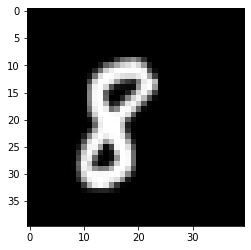

In [ ]:
plt.imshow(eight_train[2000, :, :, 0], cmap='gray')

In [ ]:
train = tf.data.Dataset.from_tensor_slices((eight_train_subset, eight_y_labels_subset))
train = train.batch(batch_size)

### Helper functions to compare output

In [ ]:
def display_actual_images(actual):
  w=10
  h=10
  fig=plt.figure(figsize=(24, 24))
  columns = 10
  rows = 1
  for i in range(1, 10):
      img = np.random.randint(10, size=(h,w))
      fig.add_subplot(rows, columns, i)
      plt.imshow(actual[i, :, :, 0], cmap='gray')
  plt.show()

In [ ]:
def display_corrected_images(corrected):
  w=10
  h=10
  fig=plt.figure(figsize=(24, 24))
  columns = 10
  rows = 1
  for i in range(1, 10):
      img = np.random.randint(10, size=(h,w))
      fig.add_subplot(rows, columns, i)
      plt.imshow(corrected[i, :, :, 0], cmap='gray')
  plt.show()


In [ ]:
def compare_images(test, corrected):
  display_actual_images(test)
  display_corrected_images(corrected)


### Custom layers for gradient flowing like previous experiments

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, activation=None,
                 bias_initializer=tf.zeros_initializer(), kernel_initializer=tf.keras.initializers.GlorotUniform()):
        '''Initializes the instance attributes'''
        super(CustomDense, self).__init__()
        self.units = units
        # define the activation to get from the built-in activation layers in Keras
        self.activation = tf.keras.activations.get(activation)
        self.bias_initializer = bias_initializer
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = self.kernel_initializer
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        b_init = self.bias_initializer
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs, weights, bias):
        '''Defines the computation from inputs to outputs'''

        return self.activation(tf.matmul(inputs, weights) + bias)

In [ ]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, padding='same', bias_initializer=tf.zeros_initializer(),
                 kernel_initializer=tf.keras.initializers.GlorotUniform(), **kwargs):
        self.filters = filters
        self.kernel_size = (kernel_size, kernel_size)
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.padding = padding
        super(CustomConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = (input_shape[:-1] + (self.filters, 0))[:-1]
        self.kernel = self.add_weight(name='kernel', shape=shape,
                                      initializer=self.kernel_initializer)

        super(CustomConv2D, self).build(input_shape)

        b_init = self.bias_initializer
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.filters,), dtype='float32'),
            trainable=True)

    def call(self, x, W, bias, strides=1):
        x = tf.nn.conv2d(x, W, strides=strides, padding='SAME')
        x = tf.nn.bias_add(x, bias)
        x = self.batch_norm(x)
        return tf.nn.relu(x)
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

### Define STN network to allow gradient flowing

In [ ]:
class LocalizationCustom(tf.keras.layers.Layer):
    def __init__(self):
        super(LocalizationCustom, self).__init__()
        self.conv1 = CustomConv2D(16, kernel_size=5)
        self.max_pool1 = tf.keras.layers.MaxPool2D()

        self.conv2 = CustomConv2D(32, kernel_size=5)
        self.max_pool2 = tf.keras.layers.MaxPool2D()

        self.conv3 = CustomConv2D(64, kernel_size=5)
        self.max_pool3 = tf.keras.layers.MaxPool2D()


         # Dense Layers
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = CustomDense(20, activation='tanh')
        
        # Output Layer
        self.dense2 = CustomDense(
            6, activation=None,
            bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0,
                                                              0.0, 1.0, 0.0]),
            kernel_initializer=tf.zeros_initializer()
        )


    def call(self, inputs, weights):
        x = self.conv1(inputs, weights[0], weights[1])
        x = self.max_pool1(x)
        x = self.conv2(x, weights[2], weights[3])
        x = self.max_pool2(x)
        x = self.conv3(x, weights[4], weights[5])
        x = self.max_pool3(x)

        x = self.flatten(x)
        x = self.dense1(x, weights[6], weights[7])
        theta = self.dense2(x, weights[8], weights[9])
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [ ]:
class GridGenerator(tf.keras.layers.Layer):

    def __init__(self, height=40, width=40):
        super(GridGenerator, self).__init__()
        self.height = height
        self.width = width

    def call(self, inputs):
      images, theta = inputs
      batch = tf.shape(images)[0]

      x = tf.linspace(-1, 1, self.width)
      y = tf.linspace(-1, 1, self.height)
          
      xx, yy = tf.meshgrid(x, y)
      xx = tf.reshape(xx, (-1,))
      yy = tf.reshape(yy, (-1,))

      homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
      homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
      homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
      homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
      return homogenous_coordinates

In [ ]:
class BilinearInterpolationSampler(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolationSampler, self).__init__()
        self.height = height
        self.width = width

    def advance_indexing(self, inputs, x, y):
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)


    def call(self, inputs, homogenous_coordinates):
        images, theta = inputs
        return self.interpolate(images, homogenous_coordinates, theta)


    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            # Clip values which are outside of the grid
            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)


        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)


        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])


#### Loss function

### We define a custom loss function to measure pixel similarity

In [ ]:
def custom_pixel_similarity_loss(example_image, corrected_images):
  corrected_images = tf.cast(corrected_images, dtype="float64")
  # if the images are identical value returned is 1 we want to minimize it so we subtract each value by 1 so that an identical image gets 0 as loss score
  return len(corrected_images) - tf.reduce_sum(tf.image.ssim(example_image, corrected_images, max_val=1.0))

In [ ]:
# An alternative loss function based on the euclidean distance
def custom_pixel_euclidean_loss(example_image, corrected_images):
    distance =0
    flat = tf.keras.layers.Flatten()
    for corrected_image in corrected_images:
      distance += tf.norm(flat(example_image) - flat(corrected_image), ord='euclidean')
    
    return distance #np.sqrt(distance)

### Helper methods for training the optimizer and optimizee

In [ ]:
def train_optimizer(train_data, epochs=100, steps_limit=None):
    for epoch in range(epochs):
        loss, val_loss  = train_data_for_one_epoch(train_data, for_optimizer=True, steps_limit=steps_limit)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f \n" % (epoch, loss, val_loss))
        prediction = model(eight_test, model.tensor_trainable_weights)
        compare_images(eight_test, prediction)

def train_model(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss  = train_data_for_one_epoch(train_data)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f \n" % (epoch, loss, val_loss))
    prediction = model(eight_test, model.tensor_trainable_weights)
    compare_images(eight_test, prediction)

def get_validation_data():
    # validation dataset
    validation_corrections = model(eight_test, model.tensor_trainable_weights)
    validation_loss = custom_pixel_similarity_loss(eight_example_image, validation_corrections)

    return validation_loss

In [ ]:
def train_data_for_one_epoch(train_data, for_optimizer=False, steps_limit=100): 
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    avg_validation_loss = []
    avg_loss = []

    for step, (x_batch_train, y_batch_train) in enumerate(train):
      
        if for_optimizer and steps_limit:
          if step == steps_limit:
            break
          loss = apply_optimizer_gradient(x_batch_train, y_batch_train)
        else:
          loss = apply_gradient(x_batch_train, y_batch_train)
        model.step_training_losses.append(loss)
        avg_loss.append(loss)

        validation_loss = get_validation_data()

        # save per step losses
        model.step_validation_losses.append(validation_loss)

        # store validation data
        avg_validation_loss.append(validation_loss)

        pbar.set_description("Training loss for step %s: %.4f val_loss %.4f" % (
            int(step), float(loss), float(validation_loss)
        ))
        pbar.update()

    avg_loss = np.mean(avg_loss)
    avg_validation_loss = np.mean(avg_validation_loss)
    return avg_loss, avg_validation_loss

def apply_optimizer_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    losses = []
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)

        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch(model.tensor_trainable_weights)

                corrections = model(x_batch_train, model.tensor_trainable_weights)  
                loss_value = custom_pixel_similarity_loss(eight_example_image, corrections)
                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
              
                losses.append(loss_value)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                              for i in range(len(model.tensor_trainable_weights))]

        
        losses = tf.reduce_sum(losses)
        
        # calculate the loss against all losses of the optimizee
        lstm_gradients = tape_master.gradient(losses, LSTM_optimizer.trainable_weights)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 0.1)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    # calculate average loss
    losses /= LSTM_optimizer.num_unroll
    return losses

def apply_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape:
        tape.watch(model.tensor_trainable_weights)

        corrections = model(x_batch_train, model.tensor_trainable_weights)  
        loss_value = custom_pixel_similarity_loss(eight_example_image, corrections)

        gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      
        loss = loss_value
        # Retrieve new results from optimizer
        lstm_optimizer_results = LSTM_optimizer(gradients) 
        # update trainable weights based on the optimer change for that step
        model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                          for i in range(len(model.tensor_trainable_weights))]    
        
    return loss

In [ ]:
def initialize_model():
    # Input Shapes
    model.localization.conv1.build((5, 5, 1, 16))
    model.localization.conv2.build((5, 5, 16, 32))
    model.localization.conv3.build((5, 5, 32, 64)) 
    
    model.localization.dense1.build((batch_size, 1600)) 
    model.localization.dense2.build((batch_size, 20))
    model.tensor_trainable_weights = model.trainable_weights

### Define the LSTM optimizer

In [ ]:
class LSTMOptimizer(tf.keras.models.Model):
    def __init__(self, hidden_size, num_layers, batch_size, num_unroll, preprocessing_value=10, **kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.lstm_cell_list = []
        self.cnn_batches = [400, 16, 12800, 32, 51200, 64]
        self.dense_batches = [32000, 20, 120, 6]
        self.batches = self.cnn_batches + self.dense_batches
        self.batch_norm = tf.keras.layers.BatchNormalization()

        self.preprocessing_value = preprocessing_value
        self.num_cnn_layers = len(self.cnn_batches)
        self.num_dense_layers = len(self.dense_batches)
        for i in range(2):
            self.lstm_cell_list.append(tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_layers)]))
            
        self.num_unroll = num_unroll
        
    def refresh_state(self): 
        # CNN state list
        self.cnn_state_list = [self.lstm_cell_list[0].get_initial_state(batch_size = self.cnn_batches[i], dtype = 'float') for i in range(self.num_cnn_layers)]
        # Dense state list
        self.dense_state_list = [self.lstm_cell_list[1].get_initial_state(batch_size = self.dense_batches[i], dtype = 'float') for i in range(self.num_dense_layers)]

    def preprocess_inputs(self, flattened_grad):
      # Preprocessing
      preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

      condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
      case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
      case_false1 = -1
      preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

      case_true2 = np.sign(flattened_grad)
      case_false2 = np.exp(self.preprocessing_value) * flattened_grad
      preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)
      return preprocessed_inputs

    def dense_layers_call(self, dense_layers_gradients):
        g_new_list = []
        lstm_dense_cells = self.lstm_cell_list[1] # dense_layers_optimizer
        for i in range(self.num_dense_layers):
            gradient = dense_layers_gradients[i] # The gradient of the i-th parameter
            state = self.dense_state_list[i]
            try:
                gradient.shape[1] # check if the tensor is 2D as this is what the cell() accepts
            except:
                gradient = tf.reshape(gradient, [gradient.shape[0], 1]) # make tensor 2D which is compatible with cell call function 
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell

            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            preprocessed_inputs = self.batch_norm(preprocessed_inputs)
            cell_output, state = lstm_dense_cells(preprocessed_inputs, state) 
            self.dense_state_list[i] = state # update the state
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
            cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1]]) # reshape the update back to the dimension of the gradient
            cell_output = cell_output * 0.007
            g_new_list.append(cell_output)
        
        g_new_list[1] = tf.squeeze(g_new_list[1]) # biases
        g_new_list[3] = tf.squeeze(g_new_list[3]) # biases

        return g_new_list
    
    
    def cnn_layers_call(self, cnn_layers_gradients):
        g_new_list = []
        lstm_cnn_cells = self.lstm_cell_list[0]
        for i in range(self.num_cnn_layers):
            gradient = cnn_layers_gradients[i] # The gradient of the i-th parameter
            state = self.cnn_state_list[i]    
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell
            preprocessed_inputs = self.preprocess_inputs(flattened_grad)
            preprocessed_inputs = self.batch_norm(preprocessed_inputs)
          
            cell_output, state = lstm_cnn_cells(preprocessed_inputs, state) 
            self.cnn_state_list[i] = state # update the state
            cell_output = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 
          
            if i % 2 == 0:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], gradient.shape[1], gradient.shape[2], gradient.shape[3]]) # reshape the update back to the dimension of the gradients
            else:
              cell_output = tf.reshape(cell_output, [gradient.shape[0], ]) # reshape bias
            cell_output = cell_output * 0.01
            g_new_list.append(cell_output)
        
        return g_new_list

    
    def call(self, gradients):
        cnn_gradients_update = []
        cnn_gradients_update = self.cnn_layers_call(gradients[:self.num_cnn_layers])
        dense_gradients_update = self.dense_layers_call(gradients[self.num_cnn_layers:])
        gradient_update_list = cnn_gradients_update + dense_gradients_update
        return gradient_update_list

### Define the optimizee network 

In [ ]:
class StnOptimizee(tf.keras.Model):
    def __init__(self, height, width):
        super(StnOptimizee, self).__init__()
        self.localization = LocalizationCustom()
        self.grid_generator = GridGenerator(height, width)
        self.bilinear = BilinearInterpolationSampler(height, width)
        # keep track of training losses
        self.training_losses, self.validation_losses = [], []
        self.step_training_losses, self.step_validation_losses = [], []

    def call(self, inputs, weights):
        image = inputs
        theta = self.localization(image, weights)
        homogenous_coordinates = self.grid_generator([image, theta])
        corrected_image = self.bilinear([image, theta], homogenous_coordinates)
        return corrected_image

In [ ]:
def display_compare_image(actual, corrected, index):
  plt.figure()
  plt.subplot(1,2,1)
  plt.title(y_test[index])
  plt.imshow(actual[index, :, :, 0], cmap='gray')

  plt.subplot(1, 2, 2)
  plt.imshow(corrected[index, :, :, 0], cmap='gray')

### Training and evaluating LSTM optimizer and optimizee

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=2, batch_size=batch_size, num_unroll=20, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)

In [ ]:
model = StnOptimizee(height=40, width=40)
initialize_model()

Training loss for step 15: 395.2040 val_loss 5755.0420: 100%|██████████| 16/16 


 Epoch: 0 => loss: 618.8326 ,avg_val_loss: 5744.6221 



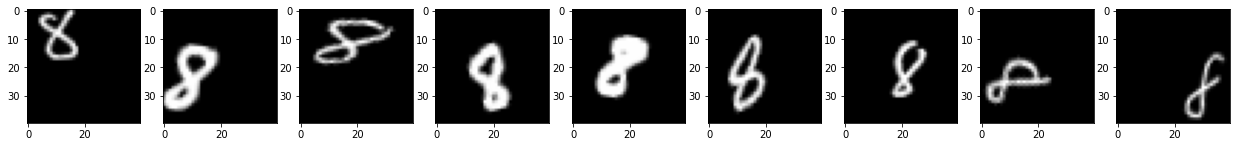

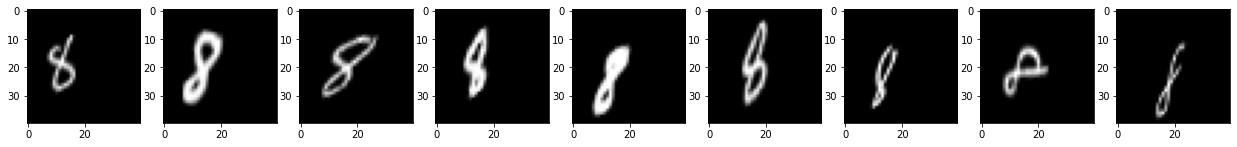

Training loss for step 15: 400.7131 val_loss 5778.5000: 100%|██████████| 16/16 


 Epoch: 1 => loss: 620.2925 ,avg_val_loss: 5761.0483 



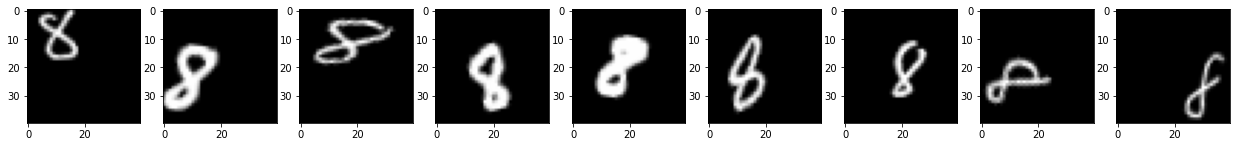

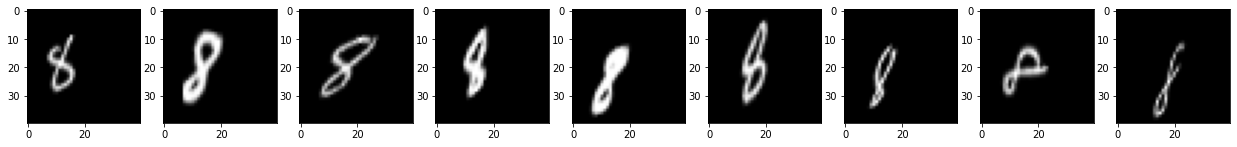

Training loss for step 15: 399.6809 val_loss 5773.5713: 100%|██████████| 16/16 


 Epoch: 2 => loss: 621.5839 ,avg_val_loss: 5763.6943 



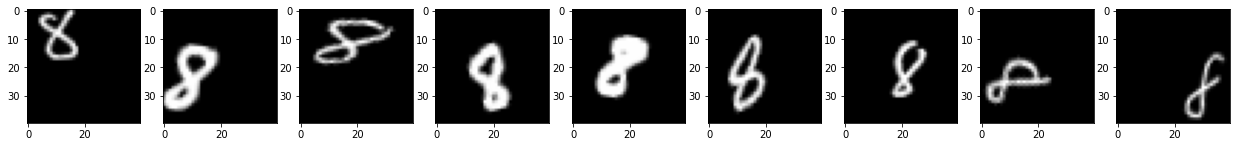

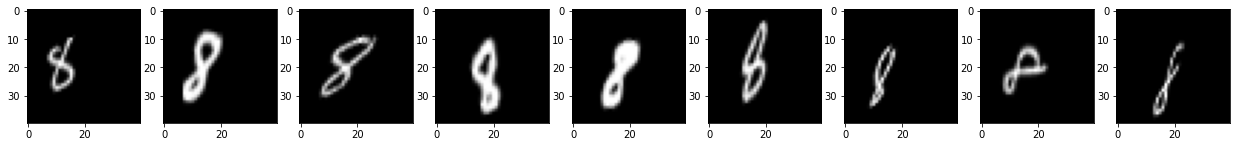

Training loss for step 15: 401.1004 val_loss 5757.6982: 100%|██████████| 16/16 


 Epoch: 3 => loss: 622.0127 ,avg_val_loss: 5761.9971 



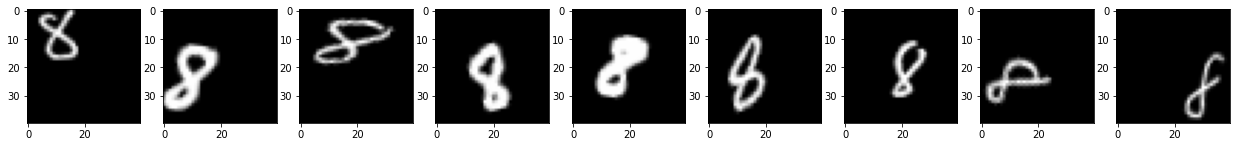

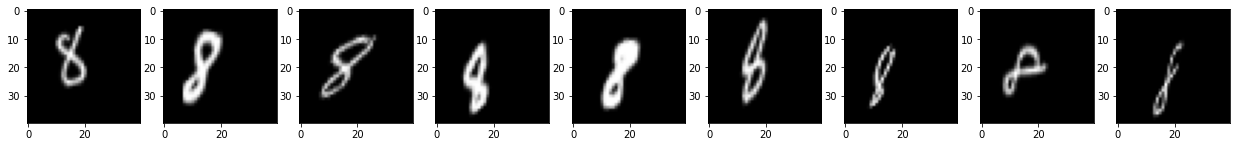

Training loss for step 15: 397.6373 val_loss 5779.3032: 100%|██████████| 16/16 


 Epoch: 4 => loss: 622.6909 ,avg_val_loss: 5765.6611 



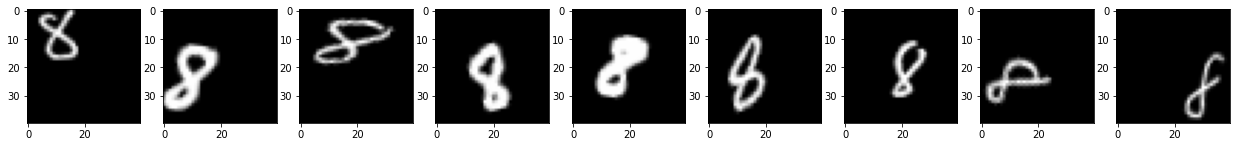

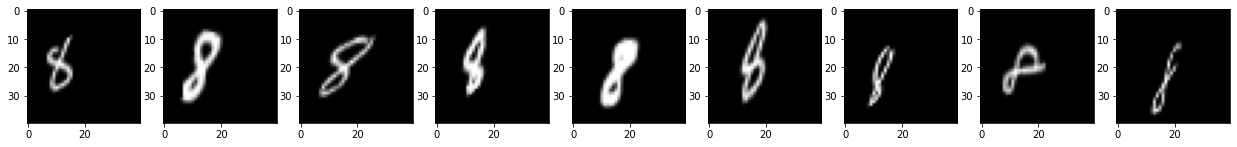

Training loss for step 15: 396.0700 val_loss 5795.6157: 100%|██████████| 16/16 


 Epoch: 5 => loss: 625.3358 ,avg_val_loss: 5781.0420 



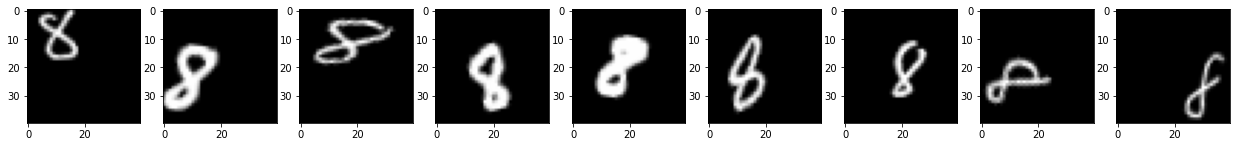

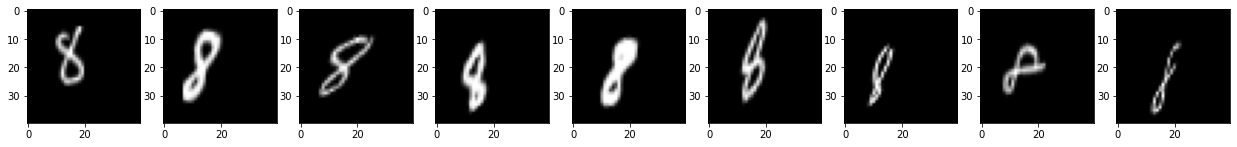

Training loss for step 15: 397.1520 val_loss 5814.0625: 100%|██████████| 16/16 


 Epoch: 6 => loss: 624.8875 ,avg_val_loss: 5782.2920 



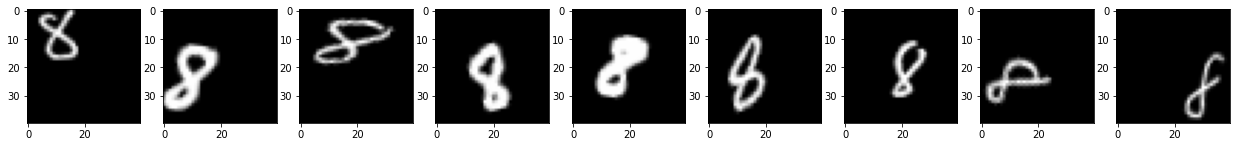

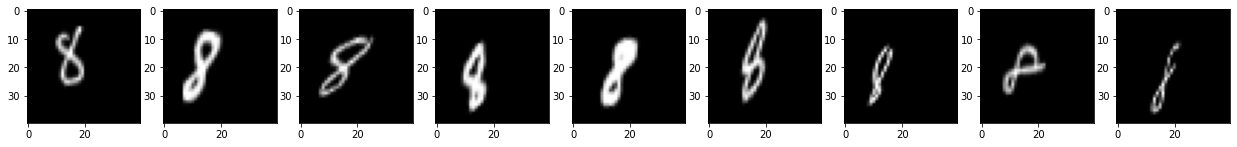

Training loss for step 15: 401.5186 val_loss 5812.7476: 100%|██████████| 16/16 


 Epoch: 7 => loss: 625.0953 ,avg_val_loss: 5789.1313 



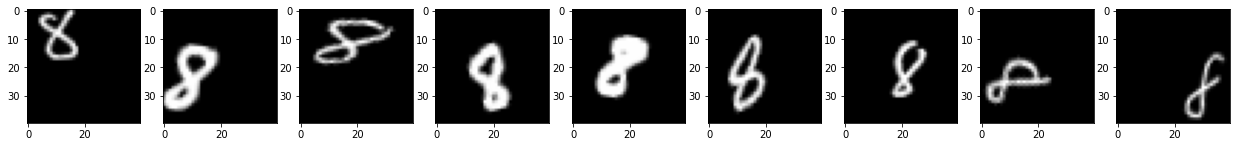

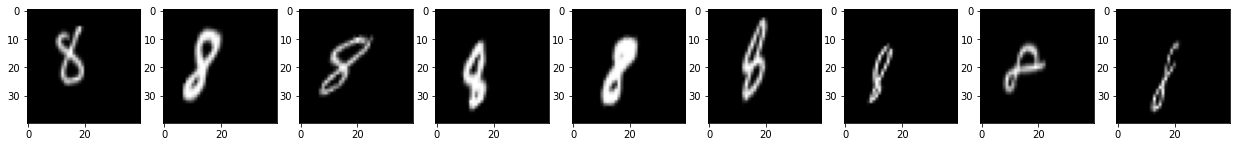

Training loss for step 15: 403.2758 val_loss 5832.8867: 100%|██████████| 16/16 


 Epoch: 8 => loss: 626.5867 ,avg_val_loss: 5799.1104 



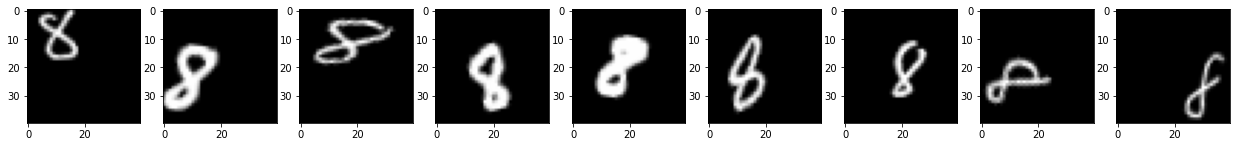

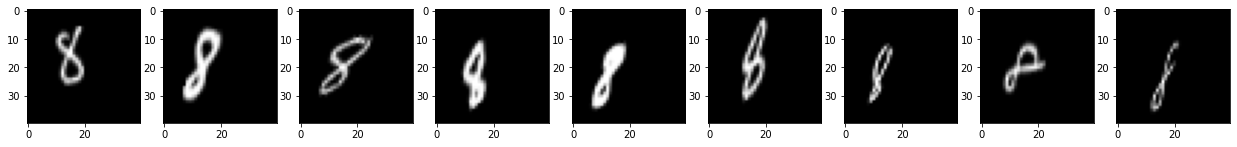

Training loss for step 15: 401.7515 val_loss 5816.1982: 100%|██████████| 16/16 


 Epoch: 9 => loss: 628.4288 ,avg_val_loss: 5797.0547 



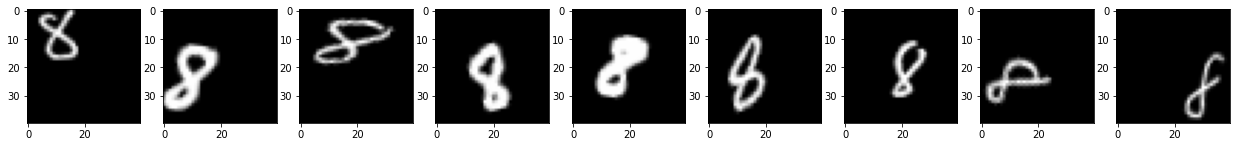

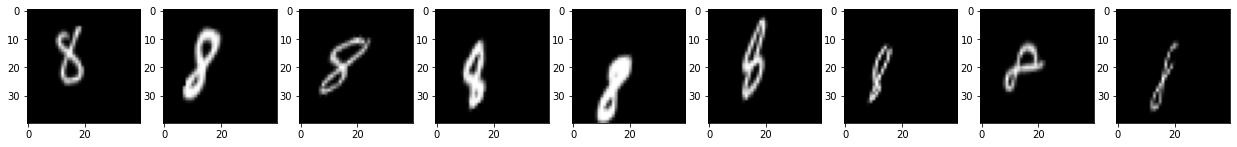

Training loss for step 15: 401.3224 val_loss 5832.7085: 100%|██████████| 16/16 


 Epoch: 10 => loss: 628.2435 ,avg_val_loss: 5803.6167 



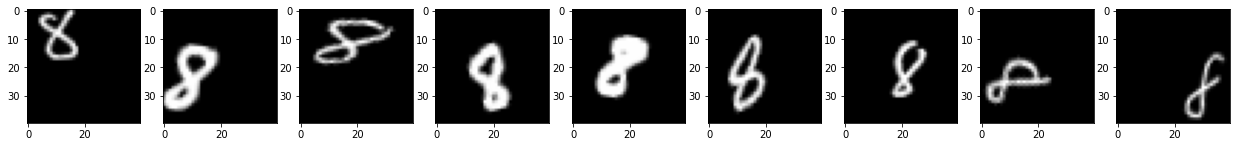

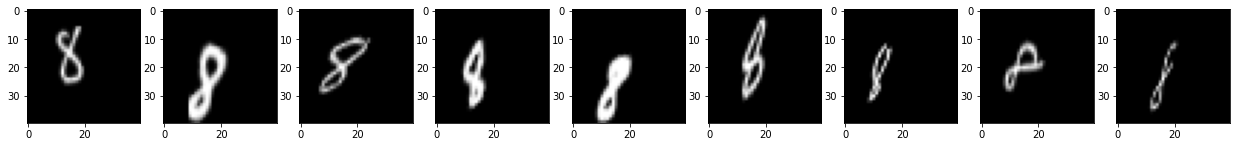

Training loss for step 15: 403.2379 val_loss 5824.9126: 100%|██████████| 16/16 


 Epoch: 11 => loss: 629.8377 ,avg_val_loss: 5810.4473 



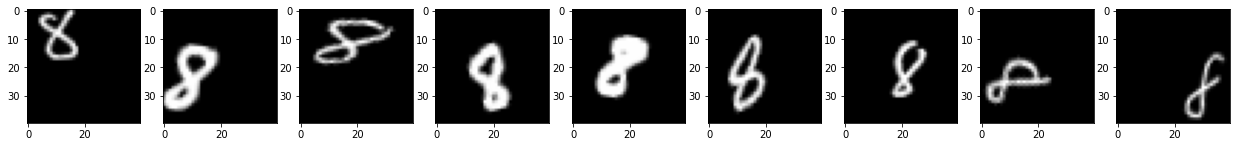

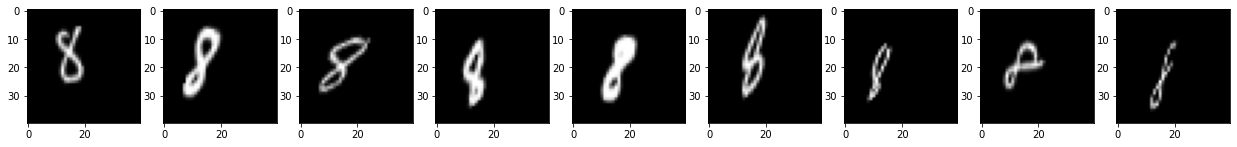

Training loss for step 15: 403.6674 val_loss 5836.6450: 100%|██████████| 16/16 


 Epoch: 12 => loss: 631.4133 ,avg_val_loss: 5827.7651 



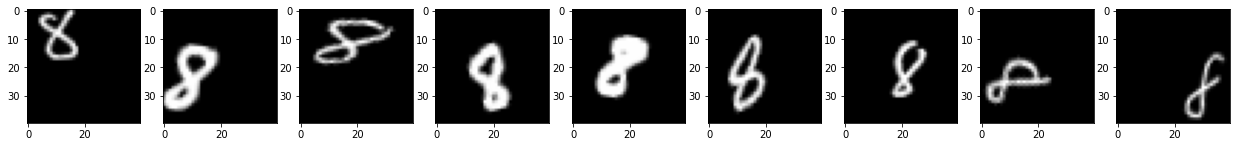

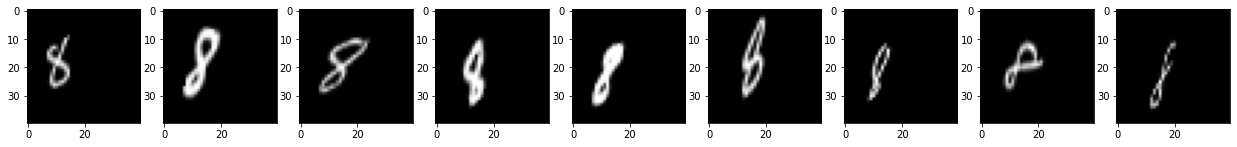

Training loss for step 15: 407.1947 val_loss 5843.2827: 100%|██████████| 16/16 


 Epoch: 13 => loss: 632.3910 ,avg_val_loss: 5839.3330 



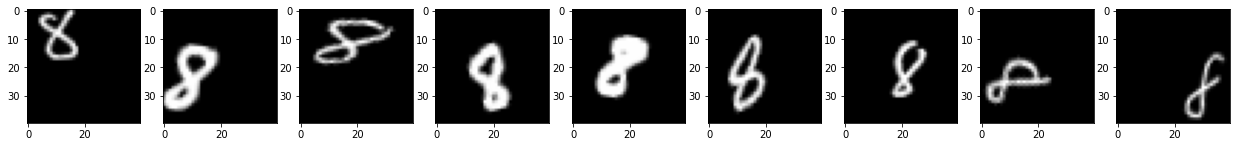

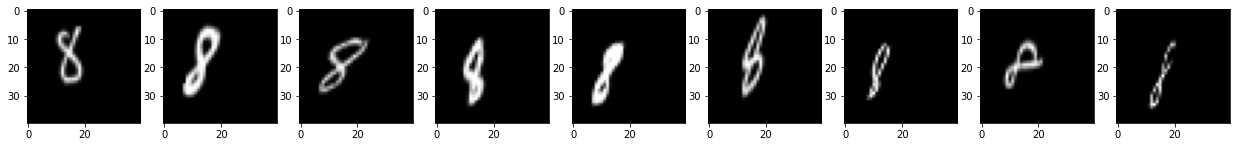

Training loss for step 15: 402.2632 val_loss 5845.9429: 100%|██████████| 16/16 


 Epoch: 14 => loss: 632.2375 ,avg_val_loss: 5843.4824 



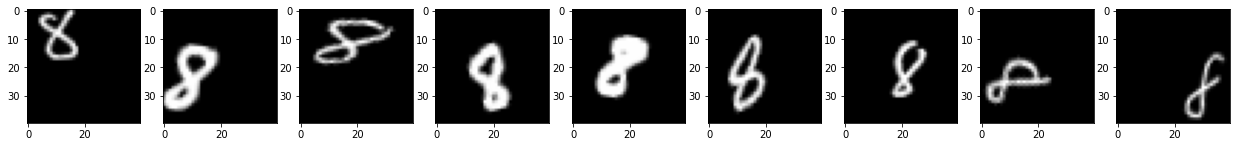

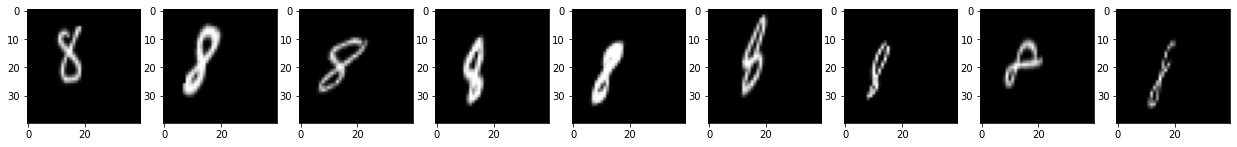

Training loss for step 15: 404.8990 val_loss 5894.9795: 100%|██████████| 16/16 


 Epoch: 15 => loss: 632.8521 ,avg_val_loss: 5861.5986 



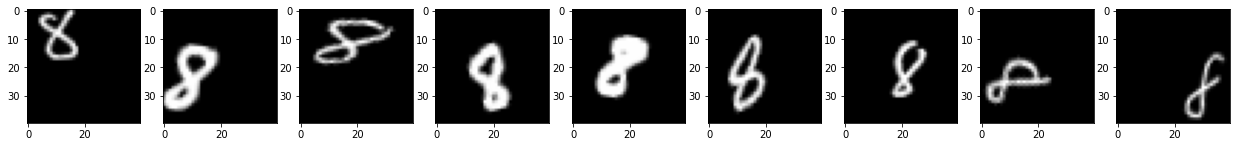

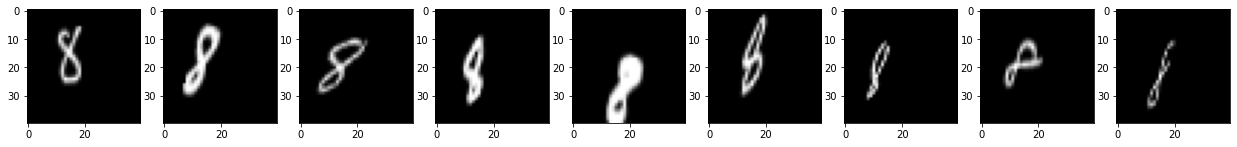

Training loss for step 15: 403.1162 val_loss 5862.5229: 100%|██████████| 16/16 


 Epoch: 16 => loss: 634.4102 ,avg_val_loss: 5866.5088 



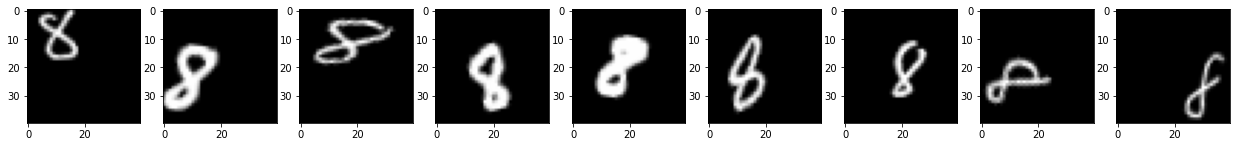

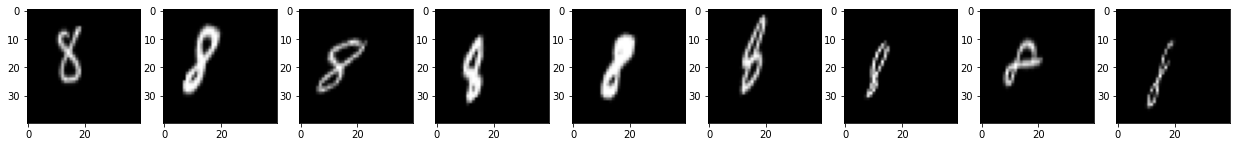

Training loss for step 15: 400.6794 val_loss 5875.9834: 100%|██████████| 16/16 


 Epoch: 17 => loss: 633.9177 ,avg_val_loss: 5870.8271 



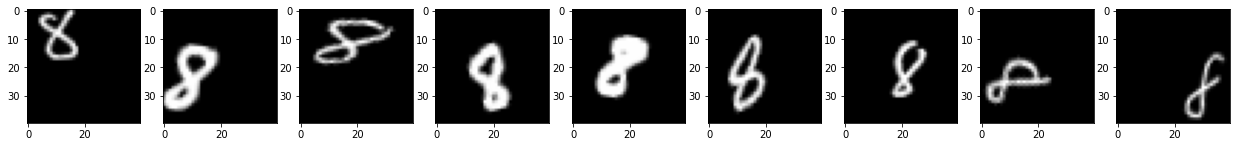

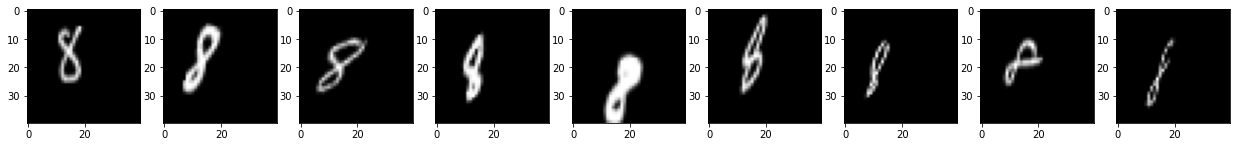

Training loss for step 15: 400.8371 val_loss 5899.6997: 100%|██████████| 16/16 


 Epoch: 18 => loss: 635.6249 ,avg_val_loss: 5894.6973 



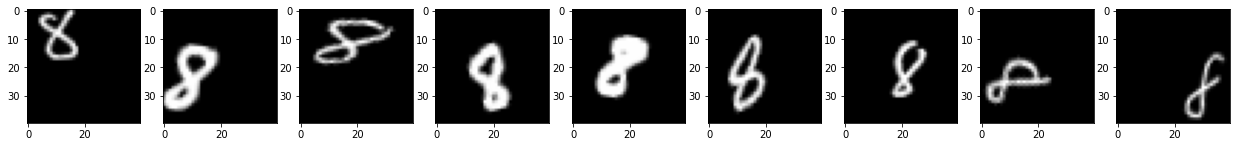

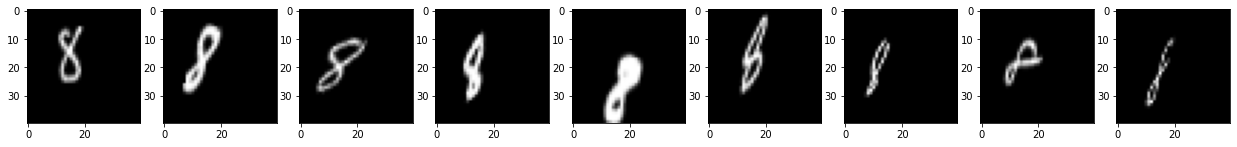

Training loss for step 15: 398.6414 val_loss 5879.2417: 100%|██████████| 16/16 


 Epoch: 19 => loss: 635.8137 ,avg_val_loss: 5895.4346 



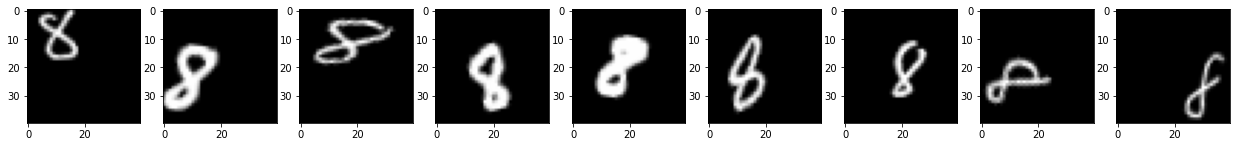

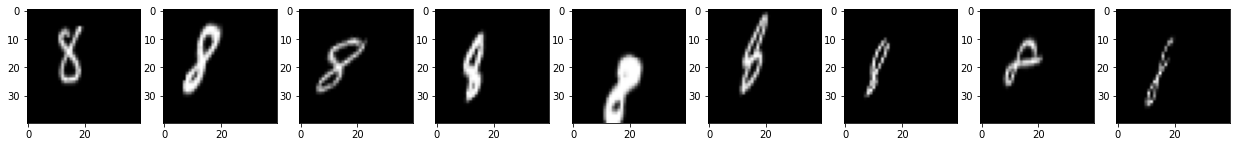

Training loss for step 15: 395.9258 val_loss 5898.8228: 100%|██████████| 16/16 


 Epoch: 20 => loss: 633.1985 ,avg_val_loss: 5889.5254 



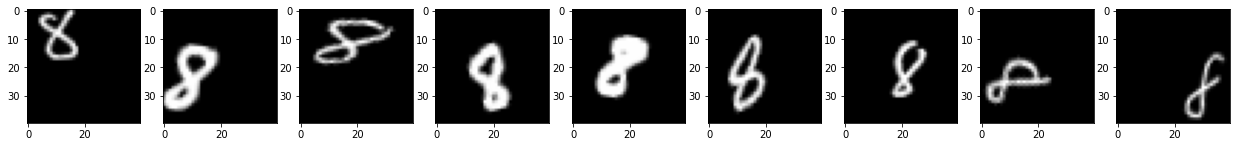

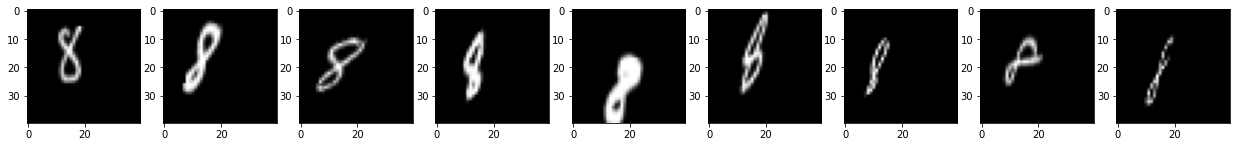

Training loss for step 15: 397.3610 val_loss 5910.7266: 100%|██████████| 16/16 


 Epoch: 21 => loss: 636.1337 ,avg_val_loss: 5908.7920 



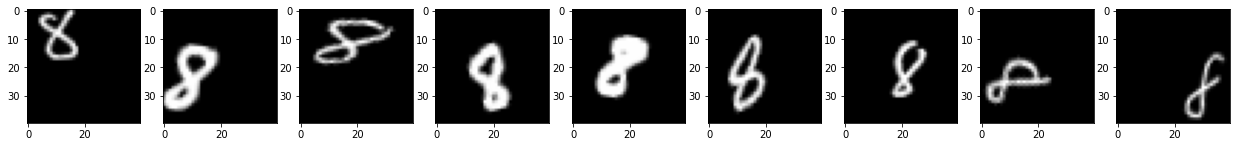

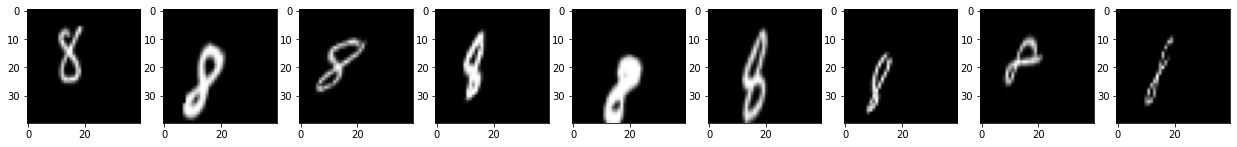

Training loss for step 15: 395.6677 val_loss 5903.6831: 100%|██████████| 16/16 


 Epoch: 22 => loss: 636.4105 ,avg_val_loss: 5909.7603 



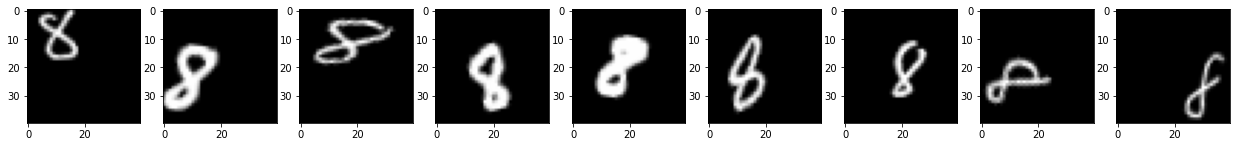

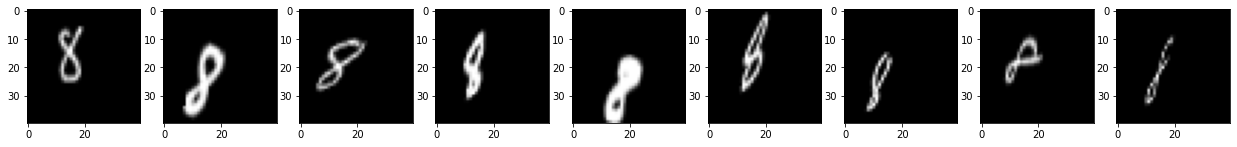

Training loss for step 15: 392.6670 val_loss 5902.7368: 100%|██████████| 16/16 


 Epoch: 23 => loss: 635.9978 ,avg_val_loss: 5912.8916 



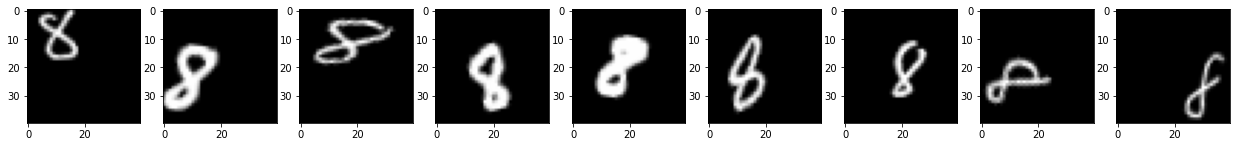

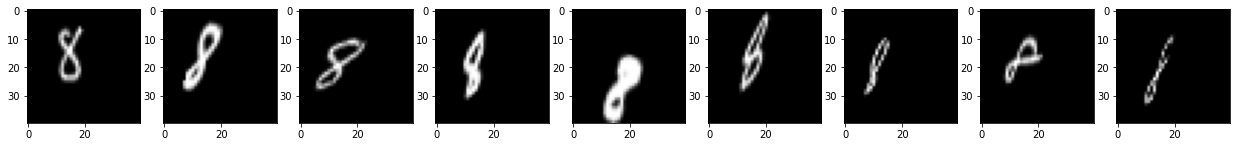

Training loss for step 15: 396.3369 val_loss 5906.1187: 100%|██████████| 16/16 


 Epoch: 24 => loss: 637.0131 ,avg_val_loss: 5918.7974 



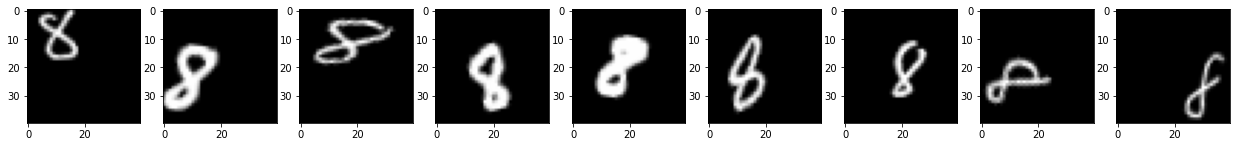

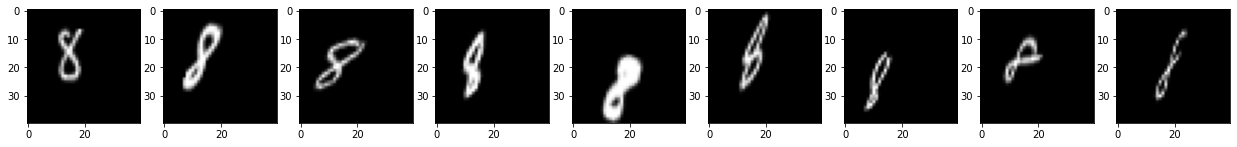

Training loss for step 15: 394.0587 val_loss 5921.4180: 100%|██████████| 16/16 


 Epoch: 25 => loss: 638.2015 ,avg_val_loss: 5930.6953 



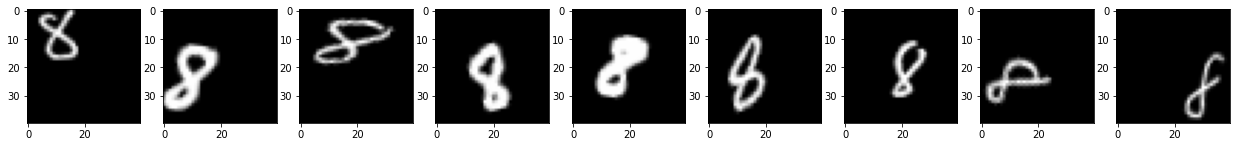

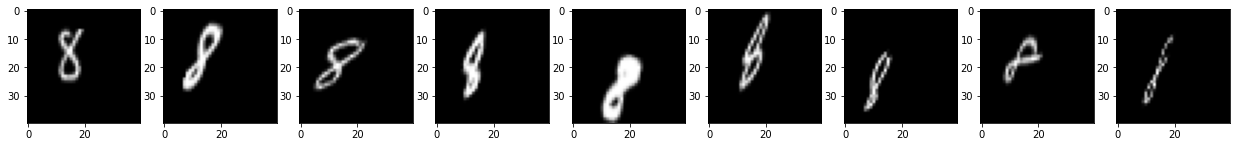

Training loss for step 15: 397.0919 val_loss 5927.3530: 100%|██████████| 16/16 


 Epoch: 26 => loss: 640.1409 ,avg_val_loss: 5950.5620 



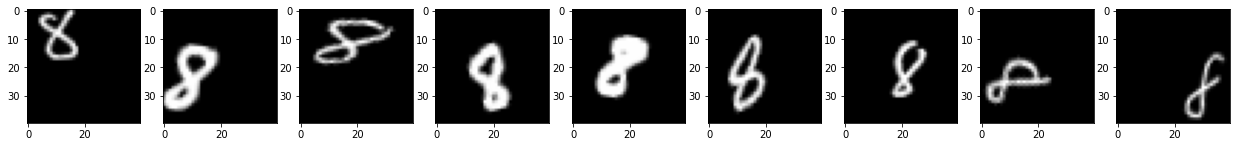

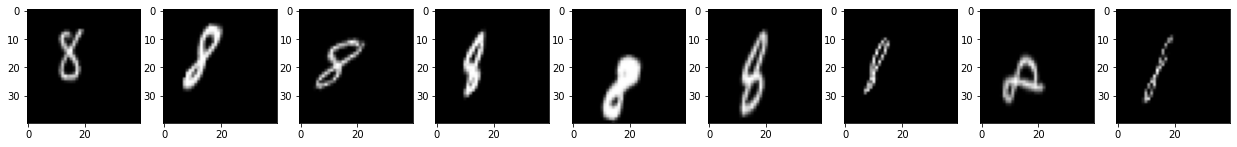

Training loss for step 15: 397.9650 val_loss 5941.8096: 100%|██████████| 16/16 


 Epoch: 27 => loss: 638.6354 ,avg_val_loss: 5949.1934 



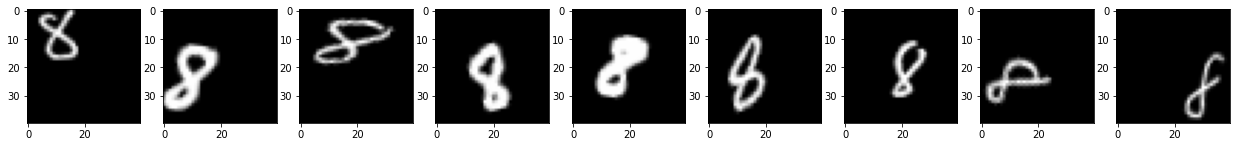

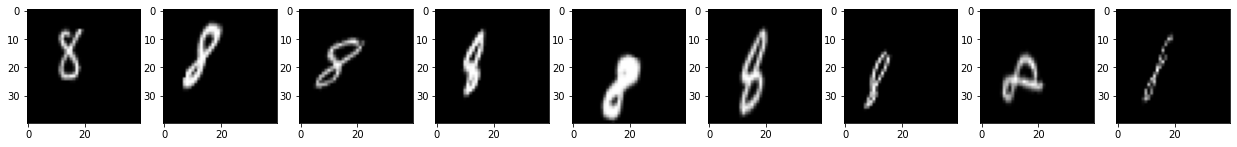

Training loss for step 15: 400.9164 val_loss 5935.4150: 100%|██████████| 16/16 


 Epoch: 28 => loss: 639.6494 ,avg_val_loss: 5947.5195 



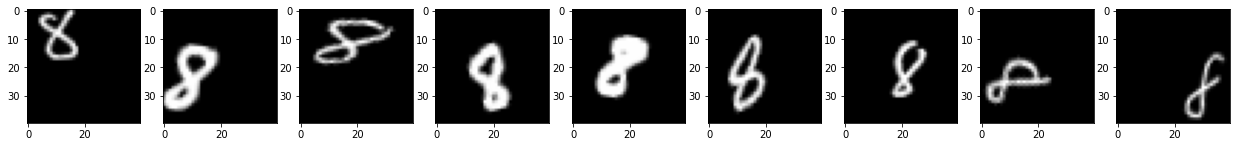

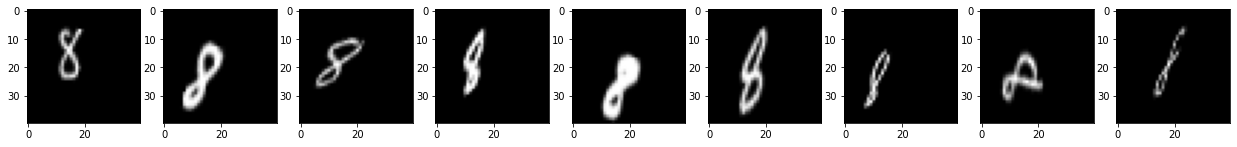

Training loss for step 15: 401.2441 val_loss 5946.8623: 100%|██████████| 16/16 


 Epoch: 29 => loss: 640.7873 ,avg_val_loss: 5935.1519 



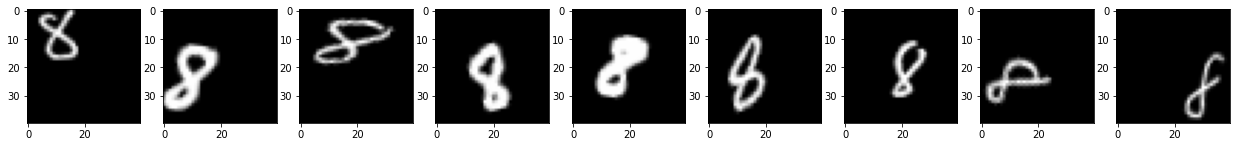

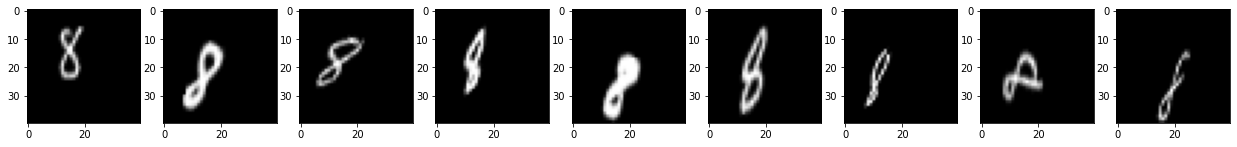

In [ ]:
train_optimizer(train, epochs=30) # Display progress of the network per epoch

## Train optimizer

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=15, num_layers=2, batch_size=batch_size, num_unroll=20, preprocessing_value=10)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)

In [ ]:
model = StnOptimizee(height=40, width=40)
initialize_model()

In [ ]:
train_optimizer(train, epochs=10)

In [ ]:
model = StnOptimizee(height=40, width=40)
initialize_model()


In [ ]:
train_model(train, epochs=20)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


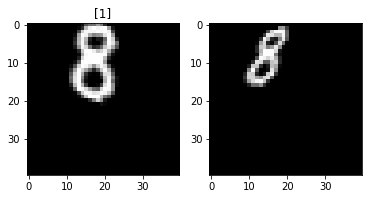

In [ ]:
prediction = model(eight_test, model.tensor_trainable_weights)
display_compare_image(eight_test, prediction, 300)

## Define hand crafted optimizers optimizee network with STN and methods

In [ ]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, [5, 5], activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D()

        self.conv2 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()

        self.conv3 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool3 = tf.keras.layers.MaxPool2D()

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(20, activation='relu')
        self.dense2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer=tf.zeros_initializer())

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        theta = self.dense2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [ ]:
class StnModel(tf.keras.Model):
    def __init__(self, height, width):
        super(StnModel, self).__init__()
        self.localization = Localization()
        self.grid_generator = GridGenerator(height, width)
        self.bilinear = BilinearInterpolationSampler(height, width)
        self.k =[]

    def call(self, inputs):
        image = inputs
        theta = self.localization(image)
        homogenous_coordinates = self.grid_generator([image, theta])
        corrected_image = self.bilinear([image, theta], homogenous_coordinates)
        return corrected_image

In [ ]:
def train_data_for_one_epoch_hand_crafted(model, optimizer, steps=None, steps_limit=None):
  # store per step
  step_train_losses, step_valid_losses = [], []

  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      if steps_limit:
        if steps == steps_limit:
        # if we reach defined number of steps break
          break
        else:
          steps += 1

      logits, loss_value = apply_gradient_hand_crafted_models(model, optimizer, x_batch_train, y_batch_train)
      
      step_train_losses.append(loss_value)
      valid_losses = perform_validation(model)
      step_valid_losses.append(valid_losses)

      pbar.set_description("Training loss for step %s: %.4f, validation loss: %.4f" % (int(step), float(loss_value), float(valid_losses)))
      pbar.update()

  return step_train_losses, step_valid_losses, steps

In [ ]:
def perform_validation(model):
  val_images = model(eight_test)
  val_loss = custom_pixel_similarity_loss(eight_example_image, val_images)
  
  return val_loss

In [ ]:
def apply_gradient_hand_crafted_models(model, optimizer, train_X, train_y):
    with tf.GradientTape() as tape:
      predictions = model(train_X)
      model.k = predictions
      current_loss = custom_pixel_similarity_loss(eight_example_image, predictions)

    gradients = tape.gradient(current_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return predictions, current_loss

In [ ]:
def train_hand_crafted_models(model, optimizer, epochs=1, steps_limit=None):
  train_losses, valid_losses = [], []
  steps_train_losses, steps_valid_losses = [], []
  steps = None
  for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    current_step_train_losses, current_step_valid_losses, steps = train_data_for_one_epoch_hand_crafted(model, optimizer, steps, steps_limit)
    train_losses.append(np.mean(current_step_train_losses))
    valid_losses.append(np.mean(current_step_valid_losses)) 
    steps_train_losses += current_step_train_losses
    steps_valid_losses += current_step_valid_losses


    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f' % (epoch, float(np.mean(current_step_train_losses)), float(np.mean(current_step_valid_losses))))
    
  history_data = {
      "loss": np.array(train_losses),
      "valid_loss": np.array(valid_losses),
      "steps_train_losses": np.array(steps_train_losses),
      "steps_valid_losses": np.array(steps_valid_losses),
  }
  return history_data

In [ ]:
adam_model = StnModel(height=40, width=40)
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=20)
rmsprop_model = StnModel(height=40, width=40)
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=20)
sgd_model = StnModel(height=40, width=40)
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=20)

  0%|          | 0/125 

Start of epoch 0


Training loss for step 0: 4.3954, validation loss: 321.9210:   1%|          | 1/125 


 Epoch 0: Train loss: 4.6721  Validation Loss: 338.1014
Start of epoch 1


Training loss for step 0: 4.5955, validation loss: 333.6968:   1%|          | 1/125 


 Epoch 1: Train loss: 4.3818  Validation Loss: 317.4652
Start of epoch 2


Training loss for step 0: 4.0847, validation loss: 314.5326:   1%|          | 1/125 


 Epoch 2: Train loss: 4.3682  Validation Loss: 316.2056
Start of epoch 3


Training loss for step 0: 4.0882, validation loss: 300.9502:   1%|          | 1/125 


 Epoch 3: Train loss: 4.2172  Validation Loss: 306.2606
Start of epoch 4


Training loss for step 0: 4.0948, validation loss: 295.6803:   1%|          | 1/125 


 Epoch 4: Train loss: 4.0906  Validation Loss: 296.7034
Start of epoch 5


Training loss for step 0: 3.7900, validation loss: 274.5628:   1%|          | 1/125 


 Epoch 5: Train loss: 3.9019  Validation Loss: 282.8425
Start of epoch 6


Training loss for step 0: 3.6068, validation loss: 269.4604:   1%|          | 1/125 


 Epoch 6: Train loss: 3.7643  Validation Loss: 273.9751
Start of epoch 7


Training loss for step 0: 3.7492, validation loss: 268.6093:   1%|          | 1/125 


 Epoch 7: Train loss: 3.6721  Validation Loss: 269.1663
Start of epoch 8


Training loss for step 0: 3.5683, validation loss: 265.2791:   1%|          | 1/125 


 Epoch 8: Train loss: 3.5901  Validation Loss: 264.9841
Start of epoch 9


Training loss for step 0: 3.5036, validation loss: 259.8973:   1%|          | 1/125 


 Epoch 9: Train loss: 3.5112  Validation Loss: 261.9393
Start of epoch 10


Training loss for step 0: 3.4836, validation loss: 255.3973:   1%|          | 1/125 


 Epoch 10: Train loss: 3.4585  Validation Loss: 257.6427
Start of epoch 11


Training loss for step 0: 3.5279, validation loss: 247.7487:   1%|          | 1/125 


 Epoch 11: Train loss: 3.3570  Validation Loss: 250.8743
Start of epoch 12


Training loss for step 0: 3.4304, validation loss: 243.7979:   1%|          | 1/125 


 Epoch 12: Train loss: 3.3684  Validation Loss: 250.6572
Start of epoch 13


Training loss for step 0: 3.3055, validation loss: 237.9236:   1%|          | 1/125 


 Epoch 13: Train loss: 3.2151  Validation Loss: 241.6282
Start of epoch 14


Training loss for step 0: 3.2951, validation loss: 231.1545:   1%|          | 1/125 


 Epoch 14: Train loss: 3.0567  Validation Loss: 232.5130
Start of epoch 15


Training loss for step 0: 3.3941, validation loss: 224.4355:   1%|          | 1/125 


 Epoch 15: Train loss: 3.0143  Validation Loss: 230.4667
Start of epoch 16


Training loss for step 0: 3.2024, validation loss: 218.2385:   1%|          | 1/125 


 Epoch 16: Train loss: 2.9274  Validation Loss: 226.4158
Start of epoch 17


Training loss for step 0: 3.2296, validation loss: 215.2395:   1%|          | 1/125 


 Epoch 17: Train loss: 2.8877  Validation Loss: 224.5712
Start of epoch 18


Training loss for step 0: 3.3057, validation loss: 218.7681:   1%|          | 1/125 


 Epoch 18: Train loss: 2.7961  Validation Loss: 219.6508
Start of epoch 19


  0%|          | 0/125 


 Epoch 19: Train loss: 2.8339  Validation Loss: 220.8828
Start of epoch 0


Training loss for step 0: 4.4951, validation loss: 316.3124:   1%|          | 1/125 


 Epoch 0: Train loss: 4.4974  Validation Loss: 323.9732
Start of epoch 1


Training loss for step 0: 4.2100, validation loss: 305.8411:   1%|          | 1/125 


 Epoch 1: Train loss: 4.3590  Validation Loss: 315.4252
Start of epoch 2


Training loss for step 0: 4.1051, validation loss: 301.6242:   1%|          | 1/125 


 Epoch 2: Train loss: 4.2143  Validation Loss: 305.2632
Start of epoch 3


Training loss for step 0: 4.1424, validation loss: 287.8342:   0%|          | 0/125 


 Epoch 3: Train loss: 4.1092  Validation Loss: 296.5568
Start of epoch 4


Training loss for step 0: 4.0508, validation loss: 277.1864:   1%|          | 1/125 


 Epoch 4: Train loss: 3.9608  Validation Loss: 287.3687
Start of epoch 5


Training loss for step 0: 4.0128, validation loss: 275.3834:   1%|          | 1/125 


 Epoch 5: Train loss: 3.8725  Validation Loss: 283.9179
Start of epoch 6


Training loss for step 0: 4.0084, validation loss: 265.1464:   1%|          | 1/125 


 Epoch 6: Train loss: 3.8088  Validation Loss: 278.5560
Start of epoch 7


Training loss for step 0: 3.8000, validation loss: 262.2544:   1%|          | 1/125 


 Epoch 7: Train loss: 3.7226  Validation Loss: 273.4424
Start of epoch 8


Training loss for step 0: 3.7990, validation loss: 262.9348:   1%|          | 1/125 


 Epoch 8: Train loss: 3.6822  Validation Loss: 271.0828
Start of epoch 9


Training loss for step 0: 3.9544, validation loss: 263.7067:   1%|          | 1/125 


 Epoch 9: Train loss: 3.6117  Validation Loss: 267.0886
Start of epoch 10


Training loss for step 0: 3.8372, validation loss: 253.3878:   1%|          | 1/125 


 Epoch 10: Train loss: 3.5614  Validation Loss: 263.8194
Start of epoch 11


Training loss for step 0: 3.7318, validation loss: 257.2332:   1%|          | 1/125 


 Epoch 11: Train loss: 3.4809  Validation Loss: 259.0112
Start of epoch 12


Training loss for step 0: 3.7534, validation loss: 244.7518:   1%|          | 1/125 


 Epoch 12: Train loss: 3.4445  Validation Loss: 256.3714
Start of epoch 13


Training loss for step 0: 3.8711, validation loss: 247.5074:   1%|          | 1/125 


 Epoch 13: Train loss: 3.3444  Validation Loss: 250.0545
Start of epoch 14


Training loss for step 0: 3.5459, validation loss: 234.5518:   1%|          | 1/125 


 Epoch 14: Train loss: 3.2831  Validation Loss: 245.2707
Start of epoch 15


Training loss for step 0: 3.6186, validation loss: 240.1469:   1%|          | 1/125 


 Epoch 15: Train loss: 3.2113  Validation Loss: 241.5578
Start of epoch 16


Training loss for step 0: 3.3814, validation loss: 238.9047:   1%|          | 1/125 


 Epoch 16: Train loss: 3.1241  Validation Loss: 236.4124
Start of epoch 17


Training loss for step 0: 3.5054, validation loss: 239.9561:   1%|          | 1/125 


 Epoch 17: Train loss: 3.0901  Validation Loss: 233.9174
Start of epoch 18


Training loss for step 0: 3.7997, validation loss: 252.0080:   1%|          | 1/125 


 Epoch 18: Train loss: 3.0216  Validation Loss: 229.9510
Start of epoch 19


  0%|          | 0/125 


 Epoch 19: Train loss: 2.9843  Validation Loss: 227.6423
Start of epoch 0


Training loss for step 0: 4.4088, validation loss: 327.5192:   1%|          | 1/125 


 Epoch 0: Train loss: 4.7857  Validation Loss: 346.7035
Start of epoch 1


Training loss for step 0: 4.3422, validation loss: 311.5446:   1%|          | 1/125 


 Epoch 1: Train loss: 4.3600  Validation Loss: 314.9082
Start of epoch 2


Training loss for step 0: 4.3155, validation loss: 310.6038:   1%|          | 1/125 


 Epoch 2: Train loss: 4.2926  Validation Loss: 311.5891
Start of epoch 3


Training loss for step 124: 4.1377, validation loss: 310.3469: 100%|██████████| 125/125 


 Epoch 3: Train loss: 4.2229  Validation Loss: 307.1485
Start of epoch 4


Training loss for step 0: 4.3207, validation loss: 299.8293:   1%|          | 1/125 


 Epoch 4: Train loss: 4.1712  Validation Loss: 302.8882
Start of epoch 5


Training loss for step 0: 4.0962, validation loss: 300.5585:   1%|          | 1/125 


 Epoch 5: Train loss: 4.1427  Validation Loss: 300.8302
Start of epoch 6


Training loss for step 0: 4.3550, validation loss: 287.4616:   1%|          | 1/125 


 Epoch 6: Train loss: 4.0813  Validation Loss: 296.3734
Start of epoch 7


Training loss for step 0: 3.9660, validation loss: 290.8640:   1%|          | 1/125 


 Epoch 7: Train loss: 4.0109  Validation Loss: 291.7061
Start of epoch 8


Training loss for step 0: 4.1445, validation loss: 294.9711:   1%|          | 1/125 


 Epoch 8: Train loss: 4.0047  Validation Loss: 292.3088
Start of epoch 9


Training loss for step 0: 4.0343, validation loss: 297.2620:   1%|          | 1/125 


 Epoch 9: Train loss: 3.9486  Validation Loss: 287.0660
Start of epoch 10


Training loss for step 0: 3.9065, validation loss: 277.1827:   1%|          | 1/125 


 Epoch 10: Train loss: 3.9061  Validation Loss: 285.6621
Start of epoch 11


Training loss for step 0: 3.9833, validation loss: 274.6925:   1%|          | 1/125 


 Epoch 11: Train loss: 3.8745  Validation Loss: 284.6745
Start of epoch 12


Training loss for step 0: 4.3016, validation loss: 289.7935:   1%|          | 1/125 


 Epoch 12: Train loss: 3.8623  Validation Loss: 282.3308
Start of epoch 13


Training loss for step 0: 3.9962, validation loss: 282.5818:   1%|          | 1/125 


 Epoch 13: Train loss: 3.8589  Validation Loss: 282.4890
Start of epoch 14


Training loss for step 0: 3.8345, validation loss: 275.1030:   1%|          | 1/125 


 Epoch 14: Train loss: 3.8580  Validation Loss: 282.4968
Start of epoch 15


Training loss for step 0: 3.8312, validation loss: 269.3488:   1%|          | 1/125 


 Epoch 15: Train loss: 3.7663  Validation Loss: 279.3394
Start of epoch 16


Training loss for step 0: 3.9334, validation loss: 285.1071:   1%|          | 1/125 


 Epoch 16: Train loss: 3.8033  Validation Loss: 281.2575
Start of epoch 17


Training loss for step 0: 3.5006, validation loss: 277.1271:   1%|          | 1/125 


 Epoch 17: Train loss: 3.8026  Validation Loss: 280.3052
Start of epoch 18


Training loss for step 0: 3.7680, validation loss: 268.4518:   1%|          | 1/125 


 Epoch 18: Train loss: 3.8006  Validation Loss: 281.5812
Start of epoch 19


Training loss for step 124: 3.4021, validation loss: 288.4402: 100%|██████████| 125/125 


 Epoch 19: Train loss: 3.7699  Validation Loss: 279.0972


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


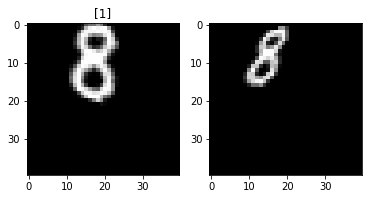

In [ ]:
lstm_prediction = model(eight_test, model.tensor_trainable_weights)
display_compare_image(eight_test, lstm_prediction, 300)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


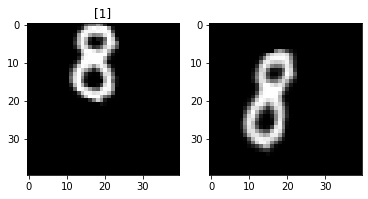

In [ ]:
adam_prediction = adam_model(eight_test)
display_compare_image(eight_test, adam_prediction, 300)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


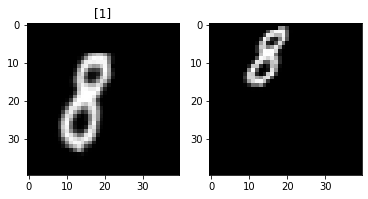

In [ ]:
rms_prop_prediction = rmsprop_model(eight_test)
display_compare_image(rms_prop_prediction, prediction, 300)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


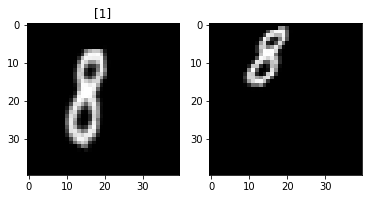

In [ ]:
sgd_prediction = sgd_model(eight_test)
display_compare_image(sgd_prediction, prediction, 300)

### Compare results 
#### Top row are the input images and bottom row are the images after applying the transformation

In [ ]:
eight_correction_adam = adam_model(eight_test)
eight_correction_rms_prop = rmsprop_model(eight_test)
eight_correction_sgd = sgd_model(eight_test)
eight_correction_lstm = model(eight_test, model.tensor_trainable_weights)

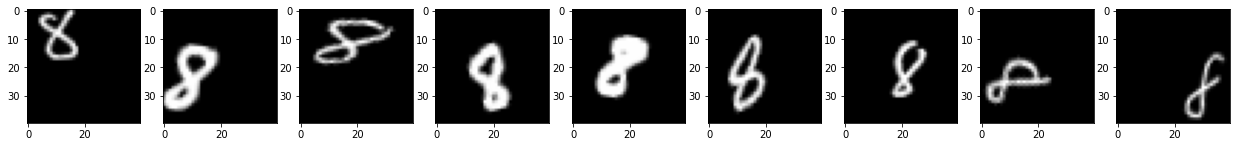

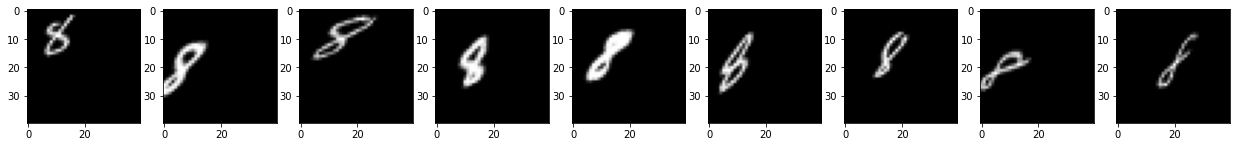

In [ ]:
compare_images(eight_test, eight_correction_lstm) # LSTM

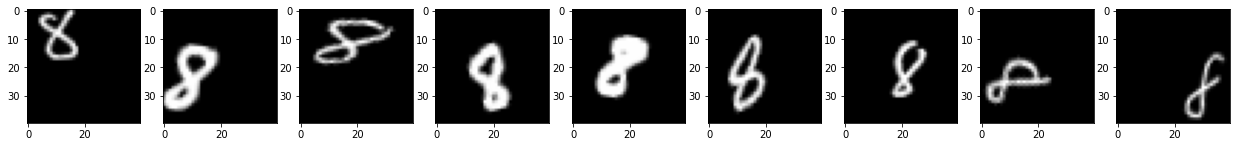

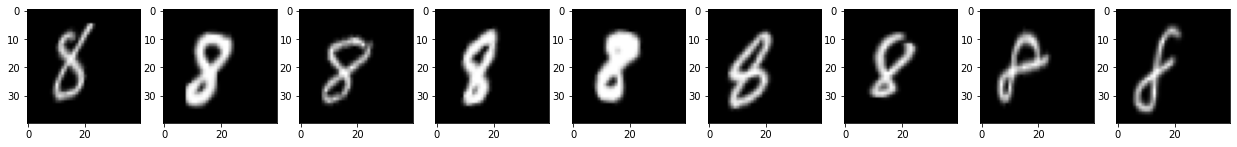

In [ ]:
compare_images(eight_test, eight_correction_adam) # ADAM

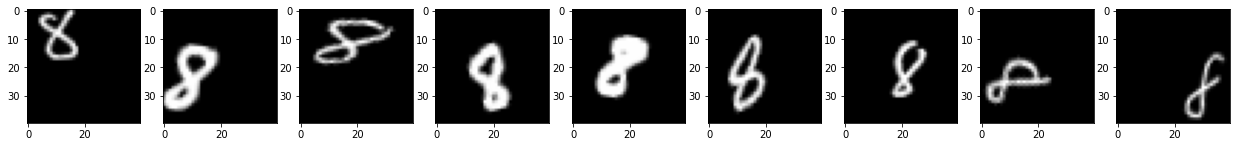

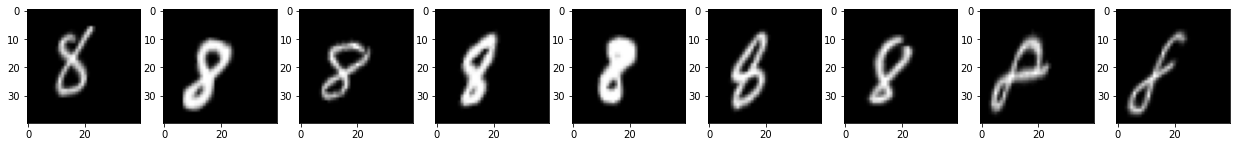

In [ ]:
compare_images(eight_test, eight_correction_rms_prop) # RMSprop

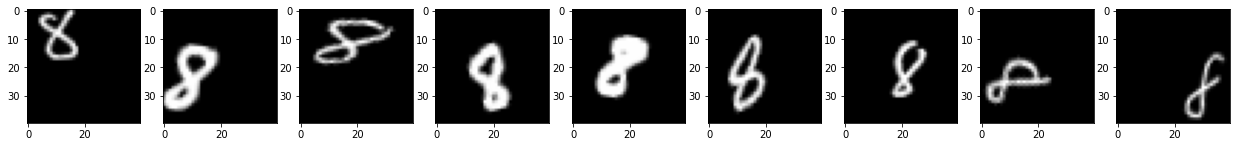

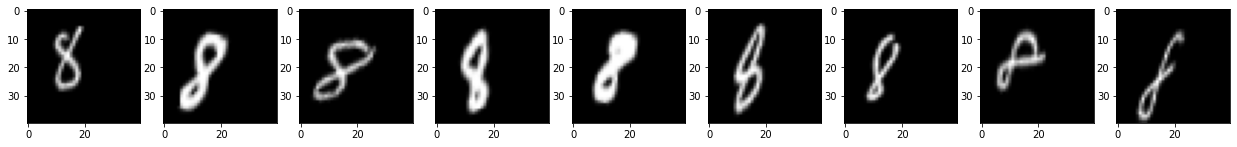

In [ ]:
compare_images(eight_test, eight_correction_sgd) # SGD

### Test generalization
Test whether it can adapt on other mnist numbers 

In [ ]:
six_test = [X_test[i,:] for i, label in enumerate(y_test) if int(label) == 6]
six_test = np.array(six_test)


one_test = [X_test[i,:] for i, label in enumerate(y_test) if int(label) == 1]
one_test = np.array(one_test)



In [ ]:
six_correction_adam = adam_model(six_test)
one_correction_adam = adam_model(one_test)

In [ ]:
six_correction_rms_prop = rmsprop_model(six_test)
one_correction_rms_prop = rmsprop_model(one_test)

In [ ]:
six_correction_sgd = sgd_model(six_test)
one_correction_sgd = sgd_model(one_test)

In [ ]:
six_correction_lstm = model(six_test, model.tensor_trainable_weights)
one_correction_lstm = model(one_test, model.tensor_trainable_weights)

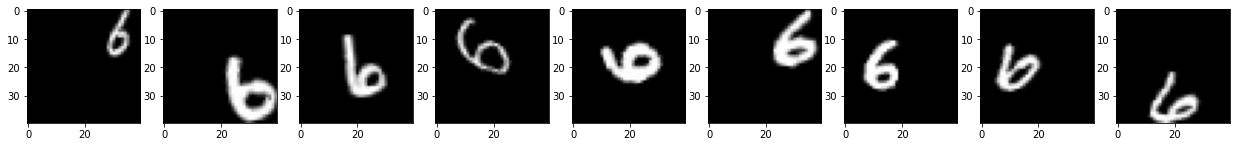

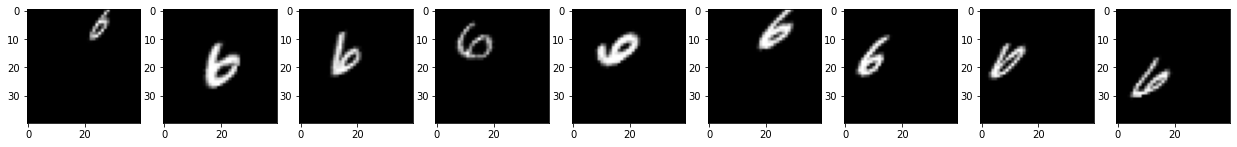

In [ ]:
# LSTM optimizer model
compare_images(six_test, six_correction_lstm)

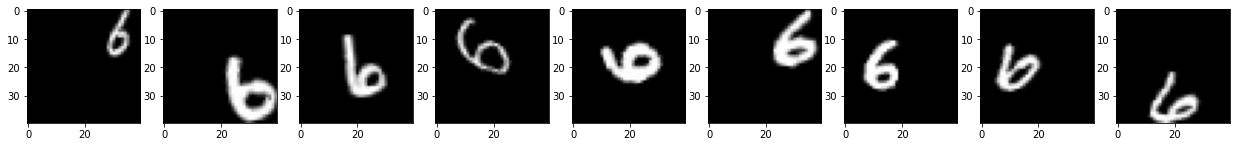

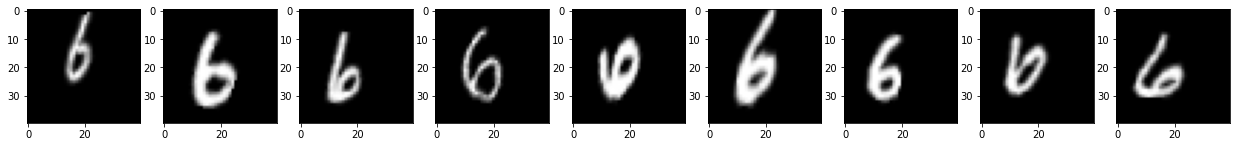

In [ ]:
# Adam optimizer model
compare_images(six_test, six_correction_adam)

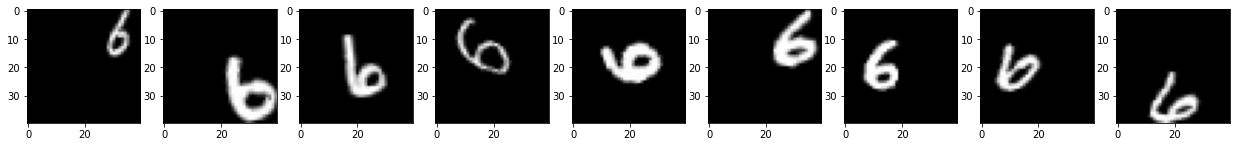

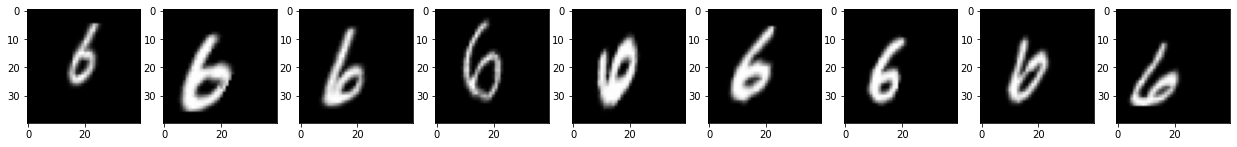

In [ ]:
# RMSprop optimizer model
compare_images(six_test, six_correction_rms_prop)

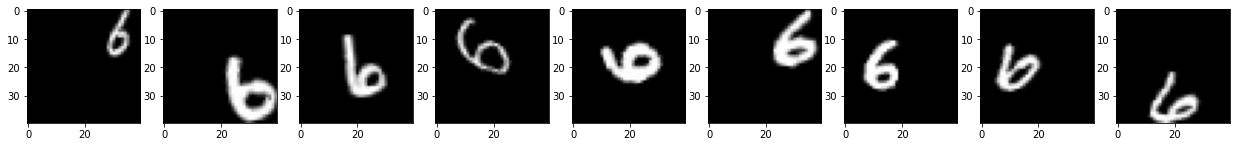

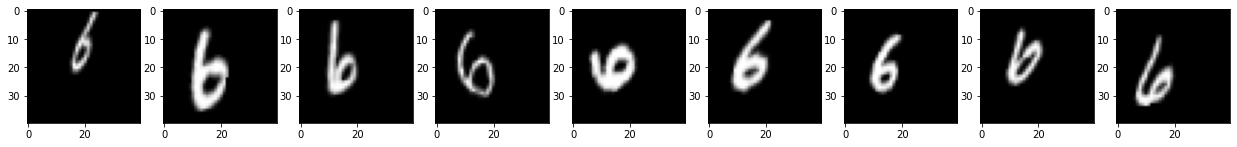

In [ ]:
# SGD optimizer model
compare_images(six_test, six_correction_sgd)

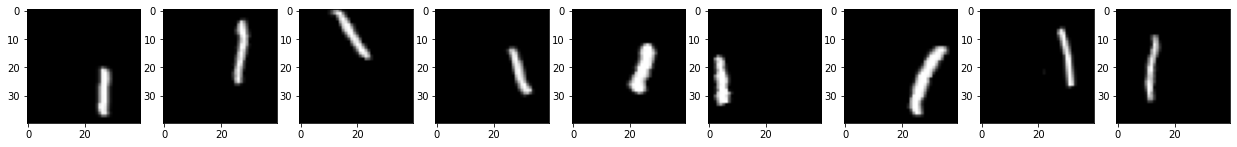

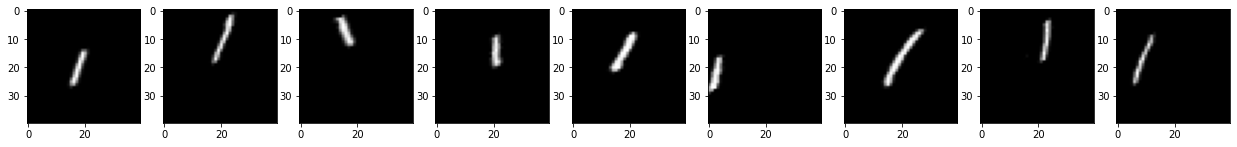

In [ ]:
# LSTM optimizer model
compare_images(one_test, one_correction_lstm)

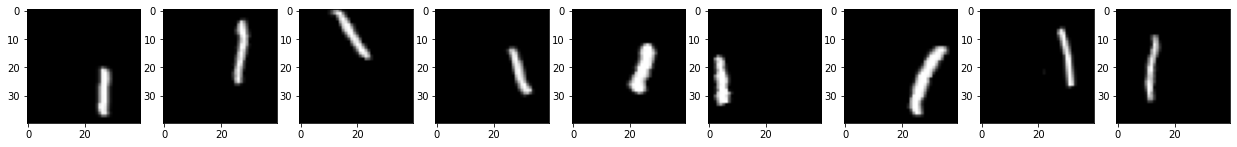

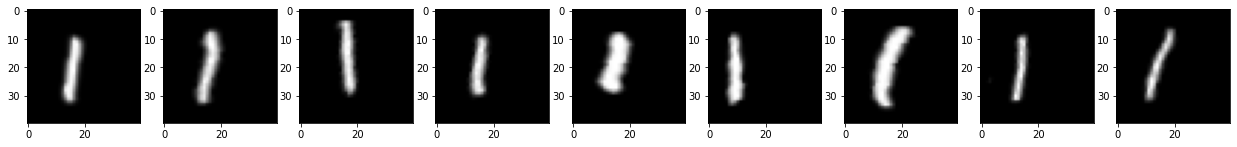

In [ ]:
# Adam optimizer model
compare_images(one_test, one_correction_adam)

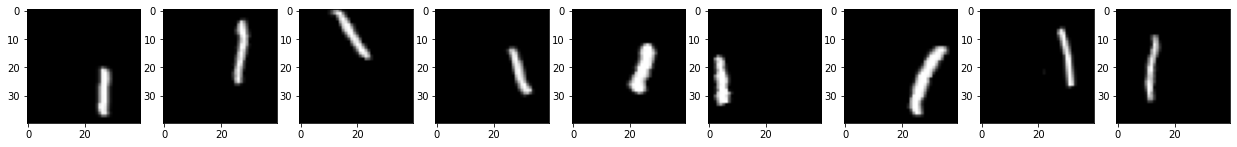

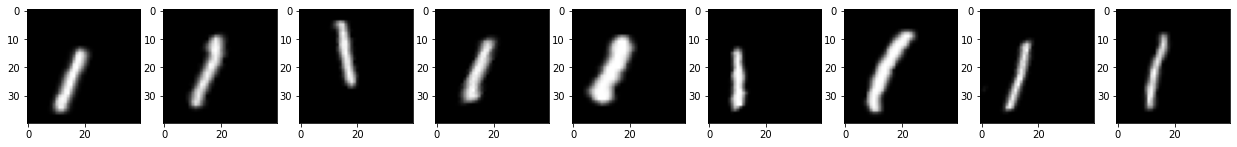

In [ ]:
# RMSprop optimizer model
compare_images(one_test, one_correction_rms_prop)

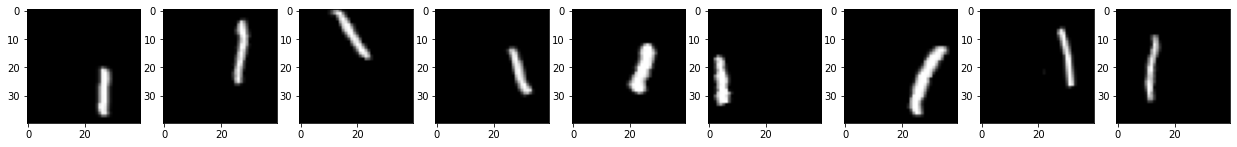

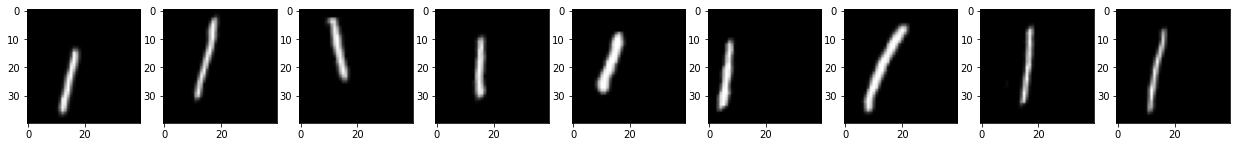

In [ ]:
# SGD optimizer model
compare_images(one_test, one_correction_sgd)